# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
import numpy as np
import seaborn as sns
import re
import gc
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType, DoubleType, LongType
from pyspark.sql.window import Window
#from pyspark.sql.functions import  desc, explode, lit, split, udf, count, avg, col, concat\
#,mean,when,lead,isnan,countDistinct,month,from_unixtime,datediff,to_timestamp
#from pyspark.sql.functions import sum as Fsum
#from pyspark.sql.functions import max as Fmax
import pyspark.sql.functions as F
import pyspark.sql.context 
import pandas as pd
import datetime

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline
import matplotlib.pyplot as plt
gc.collect()

0

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("EDA") \
    .getOrCreate()

# Part 1: Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## 1.1 Loading the Dataset 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## 1.2 Cleaning the Data

In [4]:
# Check for null values
for col in df.columns:
    print(str(col) + ' : ' + str(df.filter(df[col].isNull()).count()))

artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


In [5]:
# Check count of blank user IDs and Session IDs
for col in df['sessionId','userId'].columns:
    print(str(col) + ' : ' + str(df.filter(df[col]=='').count()))

sessionId : 0
userId : 8346


In [6]:
# Filter out the rows with blank User IDs
df = df.filter(df['userId']!='')

In [7]:
# Final User ID count
df.select('userId').distinct().count()

225

In [8]:
# Convert the UNIX millisecond timestamp to datetime
to_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0) \
             .strftime("%Y-%m-%d"))

df = df.withColumn('ts_date', to_date('ts'))
df = df.withColumn('ts_registration', to_date('registration'))

# Part 2: Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## 2.1 Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [9]:
# Users who cancelled subscription
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn_event', churn_event('page'))

In [10]:
# Users who downgraded
downgrade_event = udf(lambda x: 1 if x == 'Downgrade' else 0, IntegerType())
df = df.withColumn('downgrade_event', downgrade_event('page'))

In [11]:
# Check the distribution of churned users
print('Count of Churned Users: ' \
      + str(df.filter(df.page == 'Cancellation Confirmation').select('userId').distinct().count()))
print('Churn Rate: ' \
      + str(df.filter(df.page == 'Cancellation Confirmation').select('userId').distinct().count() / \
           df.select('userId').distinct().count()))

Count of Churned Users: 52
Churn Rate: 0.2311111111111111


In [12]:
# Check the distribution of downgraded users
print('Count of Downgraded Users: ' \
      + str(df.filter(df.page == 'Downgrade').select('userId').distinct().count()))
print('Downgrade Rate: ' \
      + str(df.filter(df.page == 'Downgrade').select('userId').distinct().count() / \
           df.select('userId').distinct().count()))

Count of Downgraded Users: 154
Downgrade Rate: 0.6844444444444444


I will define 'Churn' as the users who cancelled subscription, specifically any user who had a 'Cancellation Confirmation' in their session data. 
Downgrade events maybe worth adding as a feature to predict churn. Those users who downgraded their subscription might be strong candidates to churn, but we can explore that further.  

## 2.2 Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
# Create a user-level dataset with userId and churn / downgrade markers
df_user = df.groupBy('userId').agg({'churn_event':'max', 'downgrade_event':'max'}) \
            .withColumnRenamed('max(churn_event)', 'churn') \
            .withColumnRenamed('max(downgrade_event)', 'downgrade') 

df_user.count()

225

### 2.2.1 Initial Data Exploration
Join some existing fields into the user dataset, and add some features that we can explore by churn status.

In [14]:
df.select('userId','gender','location').distinct()

DataFrame[userId: string, gender: string, location: string]

In [15]:
# Join Gender & Location data to user data
df_demogs = df.select('userId','gender','location','level').distinct()
df_user = df_user.join(df_demogs, on='userId')

In [16]:
# Get the state information from the location field
df_user = df_user.withColumn('state', split(df_user.location,',').getItem(1))

In [17]:
# Function to plot churn rates by another variable
def compare_plot(df_user,col):
    '''
    Plots visual comparison for binary variables 
    Input:
    df: pyspark dataframe 
    col: columns to plot 
    '''
    xtab = df_user.select('userId','churn',col).toPandas()
    xtab = xtab.groupby([col,'churn']).count().reset_index()
    xtab = pd.crosstab(xtab[col], xtab.churn, xtab.userId, aggfunc='sum', normalize = 'index')
    
    xtab.plot.bar(stacked=True)
    plt.xticks(rotation=360)
    plt.legend(bbox_to_anchor=(1, 1.05), title = 'Churn')
    plt.title('Churn % by ' + str(col))
    print(xtab)
    plt.show()
    
def compare_multicat_plot(df_user,col):
    '''
    Plots visual comparison for multicategory variables 
    Input:
    df: pyspark dataframe 
    col: columns to plot 
    '''
    xtab = df_user.select('userId','churn',col).toPandas()
    
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca()
    sns.countplot(x = col,hue = 'churn',data = xtab)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1, 1.05), title = 'Churn')
    plt.title('Churn Count by ' + str(col))
    print(xtab)
    plt.show()

churn          0         1
gender                    
F       0.803571  0.196429
M       0.744792  0.255208


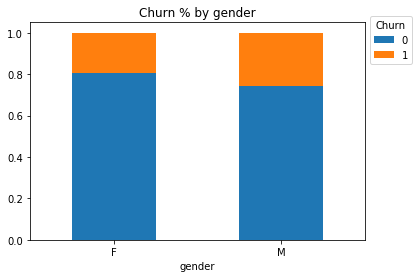

In [18]:
compare_plot(df_user, 'gender')

churn         0         1
level                    
free   0.764103  0.235897
paid   0.781818  0.218182


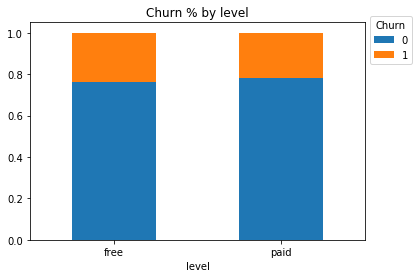

In [19]:
compare_plot(df_user, 'level')

churn             0         1
downgrade                    
0          0.772152  0.227848
1          0.772242  0.227758


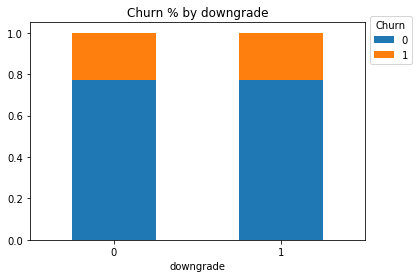

In [20]:
compare_plot(df_user, 'downgrade')

     userId  churn         state
0    100010      0            CT
1    200002      0      IL-IN-WI
2    200002      0      IL-IN-WI
3       125      1            TX
4       124      0            NJ
5        51      1            KY
6         7      0            WA
7        15      0            WV
8        54      1            WA
9        54      1            WA
10      155      0         MA-NH
11      155      0         MA-NH
12   100014      1      NY-NJ-PA
13      132      0            CO
14      132      0            CO
15      154      0      NY-NJ-PA
16      101      1            CO
17      101      1            CO
18       11      0         RI-MA
19       11      0         RI-MA
20      138      0      NY-NJ-PA
21      138      0      NY-NJ-PA
22   300017      0            MI
23   100021      1            TX
24       29      1            CA
25       29      1            CA
26       69      0            WI
27       69      0            WI
28      112      0            IN
29       4

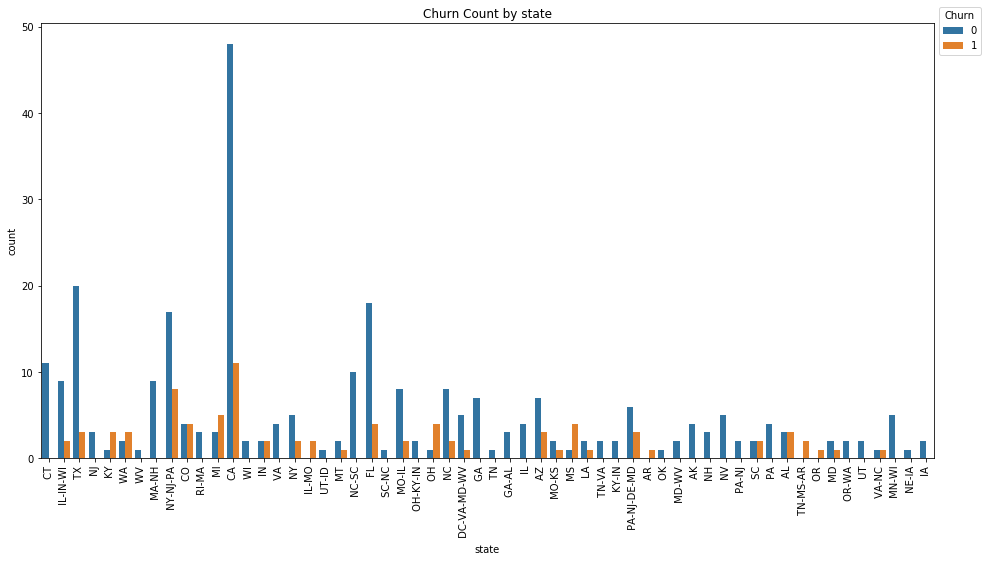

In [21]:
compare_multicat_plot(df_user, 'state')

### Findings: 

For gender it appears that males have a higher tendency to churn compared to females. 

Those in the free tier have a slightly higher tendency to churn than those in the paid tier.

Interestingly, it doe not look like those who downgraded subscription have a higher tendency to churn versus those who did not downgrade. 

As for state, it is very difficult to see the pattern at there is a very small sample size and a lot of states. The highest churn count come from California where there is also a relatively higher concentration of subscribers. 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Candidate Features:

1. Total sessions in a week
2. Total number of songs listened to
3. Total number of artists listened to
4. Number of thumbs up
5. Number of thumbs down
6. Number of friend requests sent
7. Number of add to playlist
8. Number of songs played in a session
9. Average session length
10. Average Gap (number of days) in between visit
11. Days from registration date

In [22]:
# Number of songs listened to
song_count = df.groupBy('userId').agg(countDistinct('song')).withColumnRenamed('count(DISTINCT song)','song_count')
# Number of artists listened to
artist_count = df.groupBy('userId').agg(countDistinct('artist')).withColumnRenamed('count(DISTINCT artist)','artist_count')

In [23]:
# Function to count number of instances depending on the page action
def count_page(df, condition):
    filter_str = 'page == "' + condition + '"'
    return df.filter(filter_str).groupBy('userId').count()
    
page_thumbsup = count_page(df, 'Thumbs Up').withColumnRenamed('count','thumbsup_count')
page_thumbsdown = count_page(df, 'Thumbs Down').withColumnRenamed('count','thumbsdown_count')
page_addfriend = count_page(df, 'Add Friend').withColumnRenamed('count','addfriend_count')
page_addplaylist = count_page(df, 'Add to Playlist').withColumnRenamed('count','addplaylist_count')
page_error = count_page(df, 'Error').withColumnRenamed('count','pageerror_count')
page_upgrade = count_page(df, 'Upgrade').withColumnRenamed('count','upgrade_count')
page_nextsong = count_page(df, 'NextSong').withColumnRenamed('count','nextsong_count')
page_help = count_page(df, 'Help').withColumnRenamed('count','help_count')
page_rolladvert = count_page(df, 'Roll Advert').withColumnRenamed('count','rolladvert_count')

In [24]:
# Average Session Length
avg_session_length = df.groupBy('userId').mean('length').withColumnRenamed('avg(length)','avg_session_length')

In [25]:
# Total sessions in a week
session_wk = df.groupBy('userId').agg(F.min('ts_date'), F.max('ts_date'), F.countDistinct('sessionId')) \
            .withColumnRenamed('min(ts_date)', 'min_ts_date') \
            .withColumnRenamed('max(ts_date)', 'max_ts_date') \
            .withColumnRenamed('count(DISTINCT sessionId)', 'total_sessions')

def calc_sessions_wk(session_wk, max_date, min_date, all_sessions):
    return F.when(datediff(session_wk[max_date], session_wk[min_date]) == 0, session_wk[all_sessions] / 7) \
    .otherwise((session_wk[all_sessions] / datediff(session_wk[max_date], session_wk[min_date])) * 7)

session_wk = session_wk.withColumn('avg_sessions_wk', calc_sessions_wk(session_wk, 'max_ts_date', 'min_ts_date', 'total_sessions'))

In [26]:
# Calculate visit gap

# For each user, get all the dates that they had any session (ts_date)
# Create a date_next session by shifting the index of the date_session column
# Subtract date_next_session - ts_date except when date_next_session is null (gap)
user_by_session = df.select('userId', 'ts_date').distinct().sort(['userId', 'ts_date'])
user_by_session = user_by_session.withColumn('date_next_session',lead('ts_date',1)\
                .over(Window.partitionBy('userId').orderBy('ts_date'))) \
                .filter(F.col('date_next_session').isNotNull())

# Get the average gap per user
user_by_session = user_by_session.withColumn('gap', datediff(F.col('date_next_session'), F.col('ts_date')))
user_by_session = user_by_session.groupBy('userId').mean('gap').withColumnRenamed('avg(gap)', 'avg_session_gap')

In [27]:
# Days from registration date

# For each user, get the max ts_date
user_by_registration = df.select('userId','ts_registration', 'ts_date').distinct().sort('userId',desc('ts_date'))
user_by_registration = user_by_registration.toPandas()
user_by_registration = user_by_registration.drop_duplicates(subset=['userId','ts_registration'], keep='first', inplace=False)
user_by_registration = spark.createDataFrame(user_by_registration)
user_by_registration = user_by_registration.withColumn('days_from_reg', datediff('ts_date','ts_registration'))

In [28]:
# Convert gender and level to int to be used for modeling

# Gender to int
int_gender = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df_user = df_user.withColumn('int_gender',int_gender('gender'))
gender_int = df_user.groupBy('userId').agg(F.max('int_gender')).withColumnRenamed('max(int_gender)','gender')

# Level to int
int_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df = df.withColumn('int_level',int_level('level'))
level_int = df.groupBy('userId').agg(F.max('int_level')).withColumnRenamed('max(int_level)','level')

### Merging everything into one Spark dataframe for modeling:

In [29]:
# Create a new user_df only including the userId and all relevant features for modeling
df_user = df_user.select(['userId','churn','downgrade']) 

In [30]:
# Merge all the features
df_user = df_user.join(gender_int, 'userId') \
.join(level_int, 'userId') \
.join(song_count, 'userId') \
.join(artist_count, 'userId') \
.join(page_thumbsup, 'userId') \
.join(page_thumbsdown, 'userId') \
.join(page_addfriend, 'userId') \
.join(page_addplaylist, 'userId') \
.join(page_error, 'userId') \
.join(page_upgrade, 'userId') \
.join(page_nextsong, 'userId') \
.join(page_help, 'userId') \
.join(page_rolladvert, 'userId') \
.join(avg_session_length, 'userId') \
.join(session_wk, 'userId') \
.join(user_by_session, 'userId') \
.join(user_by_registration, 'userId') 

In [31]:
# Drop some of the variables we won't be needing for modeling
columns_to_drop = ['min_ts_date', 'max_ts_date', 'ts_registration', 'ts_date']
df_user = df_user.drop(*columns_to_drop)

In [32]:
df_user.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- song_count: long (nullable = false)
 |-- artist_count: long (nullable = false)
 |-- thumbsup_count: long (nullable = false)
 |-- thumbsdown_count: long (nullable = false)
 |-- addfriend_count: long (nullable = false)
 |-- addplaylist_count: long (nullable = false)
 |-- pageerror_count: long (nullable = false)
 |-- upgrade_count: long (nullable = false)
 |-- nextsong_count: long (nullable = false)
 |-- help_count: long (nullable = false)
 |-- rolladvert_count: long (nullable = false)
 |-- avg_session_length: double (nullable = true)
 |-- total_sessions: long (nullable = false)
 |-- avg_sessions_wk: double (nullable = true)
 |-- avg_session_gap: double (nullable = true)
 |-- days_from_reg: integer (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Split into train and test set

In [33]:
df_user = df_user.drop('userId')
features = [col for col in df_user.columns if col != 'churn'] 
train, test = df_user.randomSplit([0.7, 0.3], seed=13)
train = train.cache()

### Create the model pipeline

In [34]:
def model_pipeline(classifier, params):
    """
    Function to build a model pipeline 
    Input:
    classifier: type of classifier
    params: param grid
    Output:
    ML pipeline model
    """
    assembler = VectorAssembler(inputCols=features, outputCol='features')
    scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=3,
    )
    return model

### Model 1: Logistic Regression

In [35]:
model1 = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
model1_param = ParamGridBuilder().build()
model_lr = model_pipeline(model1, model1_param)

In [36]:
fit_model_lr = model_lr.fit(train)

In [37]:
pred_lr = fit_model_lr.transform(test)

In [38]:
pred_lr.select("prediction").dropDuplicates().collect()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(pred_lr, {evaluator.metricName: "f1"})
print("f1 using Logistic Regression: {}".format(f1_score))

f1 using Logistic Regression: 0.8181818181818181


### Model 2: Random Forest

In [39]:
model2 = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
model2_param = ParamGridBuilder().build()
model_rf = model_pipeline(model2, model2_param)

In [40]:
fit_model_rf = model_rf.fit(train)

In [41]:
pred_rf = fit_model_rf.transform(test)

In [42]:
pred_rf.select("prediction").dropDuplicates().collect()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(pred_rf, {evaluator.metricName: "f1"})
print("f1 using Random Forest: {}".format(f1_score))

f1 using Random Forest: 0.8781818181818183


### Model 3: Gradient Boosting Trees (GBT)

In [43]:
model3 = GBTClassifier(featuresCol="scaled_features", labelCol="churn")
model3_param = ParamGridBuilder().build()
model_gbt = model_pipeline(model3, model3_param)

In [44]:
fit_model_gbt = model_gbt.fit(train)

In [45]:
pred_gbt = fit_model_gbt.transform(test)

In [46]:
pred_gbt.select("prediction").dropDuplicates().collect()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(pred_gbt, {evaluator.metricName: "f1"})
print("f1 using Gradient Boosting Trees: {}".format(f1_score))

f1 using Gradient Boosting Trees: 0.8876321353065539


### Hyperparameter Tuning of the best model

In [51]:
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="churn")
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 5, 10]) \
    .addGrid(gbt.maxIter, [10, 100]) \
    .build()
model_tuned = model_pipeline(gbt, paramGrid_gbt)

In [ ]:
fit_model_tuned = model_tuned.fit(train)                                       
best_model = fit_model_tuned.bestModel
best_model_pred = best_model.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
print("f1 using tuned GBT: {}".format(best_f1_score))

### Feature Importance Ranking

In [ ]:
best_model.featureImportances()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.